<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png"
         width="500" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>
            Chair of Soil Mechanics and Foundation Engineering<br>
            Geotechnical Institute<br>
            Technische Universität Bergakademie Freiberg.
        </p>
        <p>
            <a href="https://tu-freiberg.de/en/soilmechanics">
                https://tu-freiberg.de/en/soilmechanics
            </a>
        </p>
    </div>
</div>

<div style="display: flex; align-items: center;">
    <p style="margin-top: 1em;">
        To activate the <strong>interactive features</strong> when in nbviewer mode, click on &quot;Execute on Binder&quot;
        <img src="https://mybinder.org/static/favicon.ico"
             alt="Binder"
             style="height: 1.1em; vertical-align: middle; margin: 0 6px;">
        on the top right. Then, click on Run → Run All Cells.
    </p>
</div>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures as cf

#Some plot settings
import plot_functions.plot_settings
%run plot_functions/Terzaghi_FD_plot.ipynb

# One-dimensional consolidation (Terzaghi): finite difference solution

## Governing differential equation

The equation is akin to a diffusion equation

$$
    \frac{\partial u}{\partial t} = c_\text{v} \frac{\partial^2 u}{\partial z^2}
$$

In the present case we consider that the layer is sealed at the bottom and draining through the top.

Let's put this to test.

## Finite difference discretization

In the finite difference method, we introduce a grid made up, in the one-dimensional case, of a series of points. The differentials are the evaluated by finite differences between values at these points:

$$
    \frac{\partial u}{\partial z} \approx \frac{\Delta u}{\Delta z} = \frac{u_i - u_{i-1}}{z_i - z_{i-1}} = u_i'
$$

where here, backward differences were chosen (viz. forward and central differences). We also assume a constant $\Delta z$ here.

A second derivative can likewise be approximated (now using forward differences):

$$
    \frac{\partial^2 u}{\partial z^2} \approx u_i'' = \frac{u_{i+1}' - u_i'}{\Delta z}
$$

Substitution of the first derivatives yields:

$$
    \frac{\partial^2 u}{\partial z^2} \approx u_i'' = \frac{u_{i+1} - 2 u_i + u_{i-1}}{\Delta z^2}
$$

Now we do the same in time by discretizing the time interval into distinct time steps $\Delta t$ using an explicit forward Euler scheme:

$$
    \frac{\partial u}{\partial t} \approx \frac{\Delta u}{\Delta t} = \frac{u_i^{t+\Delta t} - u_i^t}{\Delta t}
$$

Our partial differential equation has now transformed into a finite difference equation evaluated at a series of points $i$ as:

$$
    \frac{u_i^{t+\Delta t} - u_i^t}{\Delta t} = c_\text{v} \frac{u_{i+1}^t - 2 u_i^t + u_{i-1}^t}{\Delta z^2}
$$

Thus, we find the solution at the next time step directly from the old solution:

$$
    u_i^{t+\Delta t} = u_i^t + c_\text{v} \frac{\Delta t}{\Delta z^2} \left( u_{i+1}^t - 2 u_i^t + u_{i-1}^t \right)
$$

or in dimensionless form:

$$
    u_i^{\tau+\Delta \tau} = u_i^\tau + c_\text{v} \frac{\Delta \tau}{\Delta \zeta^2} \left( u_{i+1}^\tau - 2 u_i^\tau + u_{i-1}^\tau \right)
$$

In [2]:
Cv_1 = 1.
Cv_2 = 10.

Next, we set the location-specific consolidation coefficient (bottom and top layer). Since we use an explicit scheme, the stability requirement

$$
    \Delta t < \frac{\Delta z^2}{2c_\text{v}}
$$

must be met.

In [3]:
dz = 0.02
L = 1.
number_of_points = int(L/dz+1)
zeta = np.linspace(0.,1.,number_of_points)
dt_max = 1./2. * dz**2/np.maximum(Cv_1,Cv_2)
dt = dt_max*0.99
t_end = 1.
time = np.linspace(0.,t_end,int(t_end/dt))

What's missing are the boundary conditions: 

$$
    \left. \frac{\partial u}{\partial \zeta} \right|_{\zeta = 0} = 0 \qquad u(\zeta = 1) = 0
$$

They can be integrated easily by manipulating the first and last equations (rows).

Additionally, we provide transition conditions between the two layers (constant mass flux):

$$
    \left. \frac{\partial u}{\partial \zeta} \right|_{\zeta = \frac{1}{2} - 0} = \left. \frac{\partial u}{\partial \zeta} \right|_{\zeta = \frac{1}{2} + 0}
$$

The final missing ingredient are the initial conditions:

$$
    u(z,t=0) = u_0(z)
$$

which are assumed to vary linearly here between an upper and a lower value.

In [4]:
u_0 = initial_pressure(1,1)#lower and upper value

Now we run the simulations by initializing solution arrays (first and second index correspond to top and bottom layer, respectively), building the finite difference system matrices A and running the time stepper for each setting on another core (i.e. in parallel).

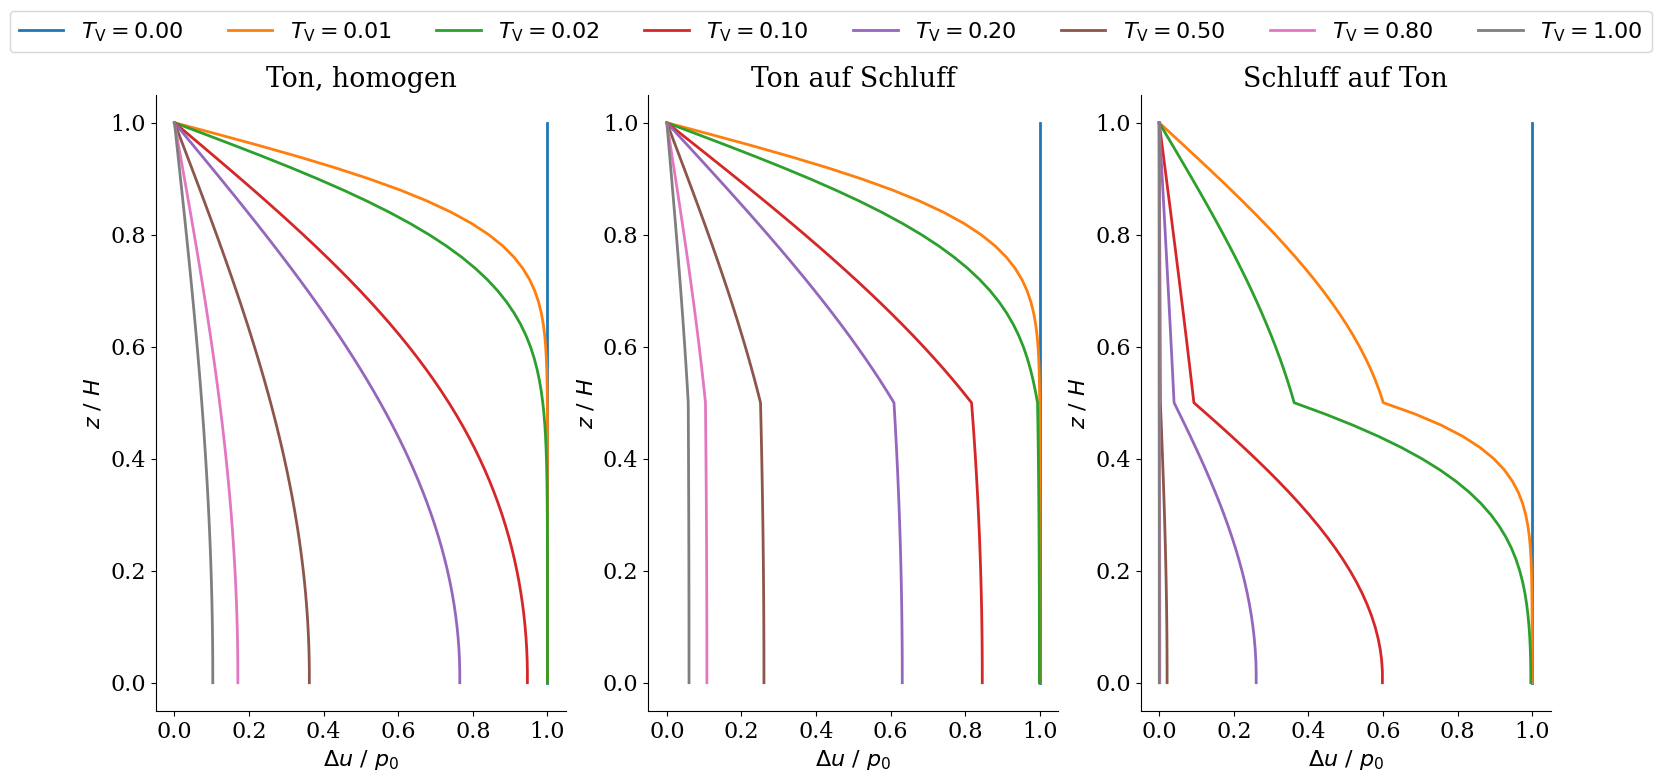

In [5]:
run_and_plot_simulation_CF(u_0,Cv_1,Cv_2,'Mehrschichtproblem_Rechteck.pdf')

Now we switch from a rectangular to an upper triangular initial excess pore pressure.

In [6]:
u_0 = initial_pressure(1,0)

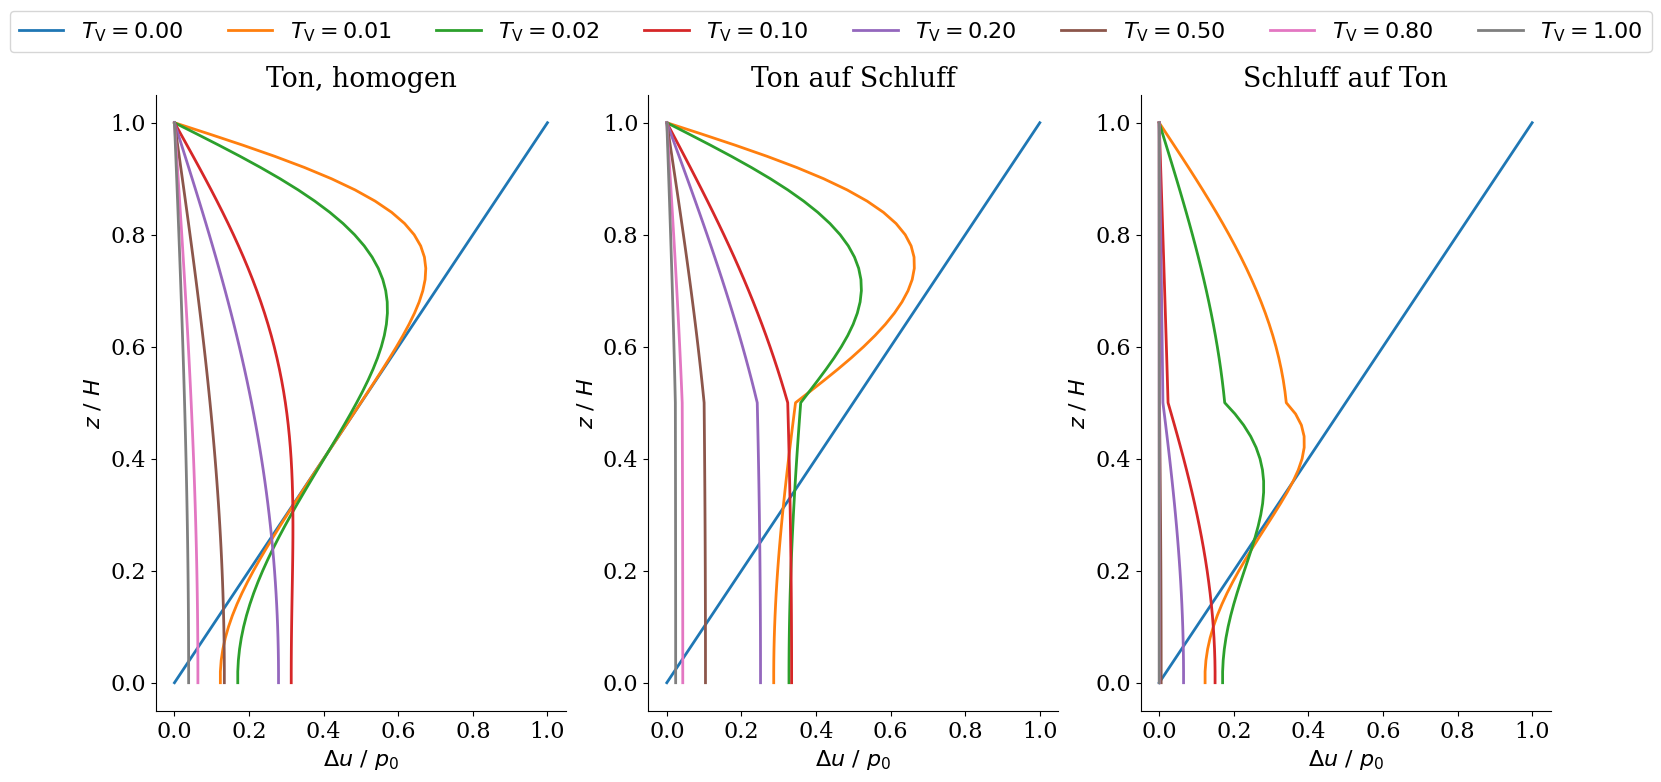

In [7]:
run_and_plot_simulation_CF(u_0,Cv_1,Cv_2,'Mehrschichtproblem_inverses_Dreieck.pdf')

Finally, we choose a lower triangular initial excess pore pressure distribution.

In [8]:
u_0 = initial_pressure(0,1)

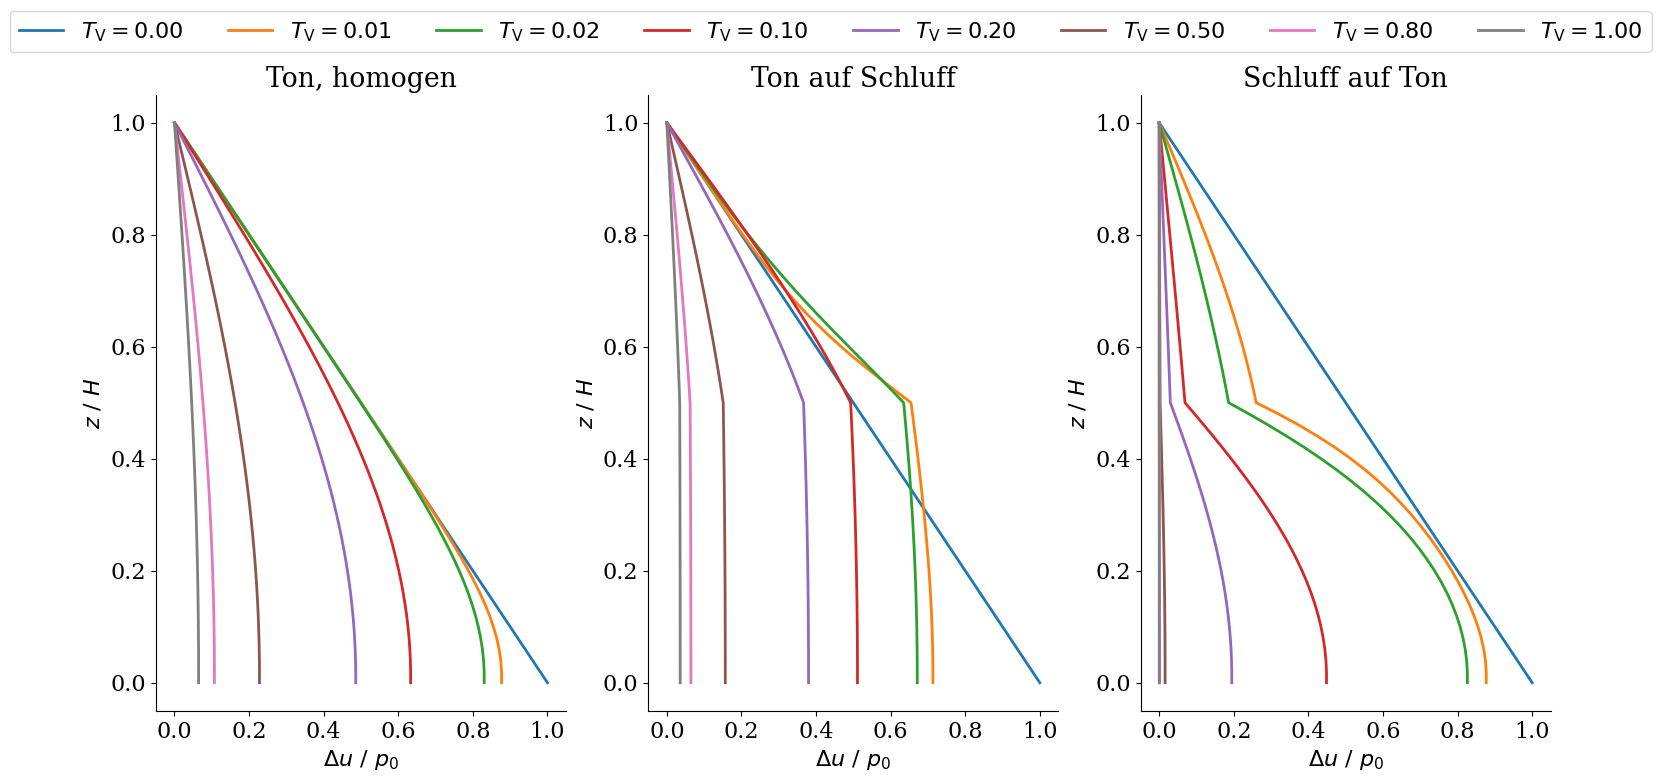

In [9]:
run_and_plot_simulation_CF(u_0,Cv_1,Cv_2,'Mehrschichtproblem_Dreieck.pdf')